## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd

from skbio import TreeNode

import qiime2
from q2_types.tree import Hierarchy
from q2_types.feature_table import FeatureTable, Composition
from q2_types.feature_data import FeatureData, Taxonomy

from qiime2.plugin import (Int, Metadata)
from q2_gneiss.plugin_setup import plugin
from gneiss.plot._heatmap import heatmap
from gneiss.util import (match, match_tips, NUMERATOR, DENOMINATOR)
from gneiss.plot._decompose import proportion_plot
from gneiss.util import NUMERATOR, DENOMINATOR

## Import files

In [9]:
table_art = qiime2.Artifact.load(os.path.join(os.getcwd(),'merged','models','gneiss','filtered-table.qza'))
table = table_art.view(pd.DataFrame)

balance_art = qiime2.Artifact.load(os.path.join(os.getcwd(),'merged','models','gneiss','balances.qza'))
balances = balance_art.view(pd.DataFrame)

tree_art = qiime2.Artifact.load(os.path.join(os.getcwd(),'merged','models','gneiss','hierarchy.qza'))
tree = tree_art.view(TreeNode)

taxa_art = qiime2.Artifact.load(os.path.join(os.getcwd(),'merged','features/taxonomy.qza'))
taxa = taxa_art.view(pd.DataFrame)

metadata = pd.read_table(os.path.join(os.getcwd(),'mappings_LDA.txt'), index_col=0)

In [3]:
metadata.head()

,TimePoint,Biostimulant,Rep,Area,SPAD.avg,Leaves,Stems,Root,Tot,Biostimulant_TimePoint,LDA1_area_vs_treatment,LDA1_biomass_vs_treatment
X.SampleID,,,,,,,,,,,,
B2CT0-1,T0,Control,1,110.640,39.93,340.0,215,119,674,Control_T0,-2.876004,-5.792131
B2CT0-2,T0,Control,2,104.906,45.17,412.0,265,129,806,Control_T0,-2.908074,-5.784064
B2CT0-3,T0,Control,3,115.360,36.63,360.0,220,92,672,Control_T0,-2.849605,-5.850545
B2CT0-4,T0,Control,4,97.690,37.07,286.0,212,95,593,Control_T0,-2.948432,-5.831420
B2CT0-5,T0,Control,5,94.630,35.73,270.0,146,87,503,Control_T0,-2.965547,-5.845481


## Define variables to analyze

In [4]:
n_features = 10
fname = 'feature'

In [5]:
taxadf = pd.DataFrame(taxa.Taxon.apply(lambda x: x.split(';')).values.tolist(),
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'],
                    index=taxa.index)

## Normalization of the table 

This is actually copied from the proportions_plot function of the gneiss decompose.py. Why is it so basic?

In [6]:
ptable = table.apply(lambda x: 100*x / x.sum(), axis=1)

In [7]:
viz = qiime2.Visualization.load('regression_summary.qzv')
viz.export_data('ols_summary_dir')

In [8]:
adj_pvals = pd.read_csv('ols_summary_dir/fdr-corrected-pvalues.csv', index_col=0)

In [9]:
cp = adj_pvals.reset_index()
cp = cp.rename(columns={'index': 'balance'})

OLS_df =  pd.melt(cp, id_vars='balance', var_name='Covariate',
                  value_name='Corrected_Pvalue')
OLS_df = OLS_df[(OLS_df['Corrected_Pvalue']<0.1) & (OLS_df['Covariate'] != 'Intercept')]

In [10]:
OLS_df

,balance,Covariate,Corrected_Pvalue
612,y0,TimePoint[T.T1],7.109480e-12
613,y1,TimePoint[T.T1],4.379658e-10
618,y6,TimePoint[T.T1],1.259556e-06
623,y11,TimePoint[T.T1],4.997843e-03
625,y13,TimePoint[T.T1],4.676734e-02
629,y17,TimePoint[T.T1],3.425195e-04
641,y29,TimePoint[T.T1],3.270616e-02
648,y36,TimePoint[T.T1],7.783282e-02
651,y39,TimePoint[T.T1],5.181964e-02
661,y49,TimePoint[T.T1],3.289080e-07


In [11]:
OLS_df.Covariate.unique()

array(['TimePoint[T.T1]', 'TimePoint[T.T2]', 'TimePoint[T.T3]',
       'Biostimulant[T.Endomaxx]', 'Biostimulant[T.Inocucor]',
       'Biostimulant[T.Pathway]', 'Biostimulant[T.Sumagrow]',
       'Biostimulant_TimePoint[T.Control_T1]',
       'Biostimulant_TimePoint[T.Control_T2]',
       'Biostimulant_TimePoint[T.Control_T3]',
       'Biostimulant_TimePoint[T.Endomaxx_T0]',
       'Biostimulant_TimePoint[T.Endomaxx_T1]',
       'Biostimulant_TimePoint[T.Endomaxx_T2]',
       'Biostimulant_TimePoint[T.Endomaxx_T3]',
       'Biostimulant_TimePoint[T.Inocucor_T0]',
       'Biostimulant_TimePoint[T.Inocucor_T1]',
       'Biostimulant_TimePoint[T.Inocucor_T2]',
       'Biostimulant_TimePoint[T.Inocucor_T3]',
       'Biostimulant_TimePoint[T.Pathway_T0]',
       'Biostimulant_TimePoint[T.Pathway_T1]',
       'Biostimulant_TimePoint[T.Pathway_T2]',
       'Biostimulant_TimePoint[T.Pathway_T3]',
       'Biostimulant_TimePoint[T.Sumagrow_T0]',
       'Biostimulant_TimePoint[T.Sumagrow_T1]',
  

In [12]:
OLS_df = OLS_df.replace(['TimePoint[T.T1]', 'TimePoint[T.T2]', 'TimePoint[T.T3]',
       'Biostimulant[T.Endomaxx]', 'Biostimulant[T.Inocucor]',
       'Biostimulant[T.Pathway]', 'Biostimulant[T.Sumagrow]',
       'Biostimulant_TimePoint[T.Control_T1]',
       'Biostimulant_TimePoint[T.Control_T2]',
       'Biostimulant_TimePoint[T.Control_T3]',
       'Biostimulant_TimePoint[T.Endomaxx_T0]',
       'Biostimulant_TimePoint[T.Endomaxx_T1]',
       'Biostimulant_TimePoint[T.Endomaxx_T2]',
       'Biostimulant_TimePoint[T.Endomaxx_T3]',
       'Biostimulant_TimePoint[T.Inocucor_T0]',
       'Biostimulant_TimePoint[T.Inocucor_T1]',
       'Biostimulant_TimePoint[T.Inocucor_T2]',
       'Biostimulant_TimePoint[T.Inocucor_T3]',
       'Biostimulant_TimePoint[T.Pathway_T0]',
       'Biostimulant_TimePoint[T.Pathway_T1]',
       'Biostimulant_TimePoint[T.Pathway_T2]',
       'Biostimulant_TimePoint[T.Pathway_T3]',
       'Biostimulant_TimePoint[T.Sumagrow_T0]',
       'Biostimulant_TimePoint[T.Sumagrow_T1]',
       'Biostimulant_TimePoint[T.Sumagrow_T2]',
       'Biostimulant_TimePoint[T.Sumagrow_T3]'],
               ['T1','T2','T3','Endomaxx','Inocucor','Pathway','Sumagrow',
               'Control_T1','Control_T2','Control_T3',
               'Endomaxx_T0','Endomaxx_T1','Endomaxx_T2','Endomaxx_T3',
               'Inocucor_T0','Inocucor_T1','Inocucor_T2','Inocucor_T3',
               'Pathway_T0','Pathway_T1','Pathway_T2','Pathway_T3',
               'Sumagrow_T0','Sumagrow_T1','Sumagrow_T2','Sumagrow_T3'])

# Boxplot test

These are taken from https://github.com/qiime2/q2-gneiss/blob/master/q2_gneiss/plot/_plot.py and https://github.com/biocore/gneiss/blob/master/gneiss/plot/_decompose.py

I edited and rearranged them, so to produce a functioning dataset for ONE balance. Do not run this cell, if you want to have a summary of all balances.

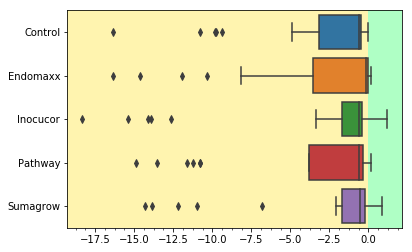

In [13]:
%matplotlib inline
from gneiss.plot import balance_boxplot, balance_barplots
data = pd.merge(balances, metadata, left_index=True, right_index=True)

ax = balance_boxplot('y1', data, y='Biostimulant',
                     num_color='#FFF4AF', denom_color='#AFFFC5')


## Define lists of balances

We will use here the same balance list that we used to produce all the visualizations in qiime. The following cells are actually a replicate of those visualization but, instead of producing qiime2 artifacts, will produce a huge (and I underline huge) dataframe containing all the balances, all the respective taxa for each balance (with classification) and in which part of the balance they are (numerator or denominator). 

When you start this cell, you will have time for a coffee. Maybe more than one.

In [58]:
#!pip install tqdm -t /home/andrea.nuzzo/bin
#!!export PATH=$PATH:/home/andrea.nuzzo/.local/bin

  Using cached https://files.pythonhosted.org/packages/79/43/19c9fee28110cd47f73e6bc596394337fe9f3e5825b4de402bbf30b3beb5/tqdm-4.26.0-py2.py3-none-any.whl


In [14]:
from tqdm import tqdm

def num_clade(i):
    return tree.find(i)[NUMERATOR]

def denom_clade(i):
    return tree.find(i)[DENOMINATOR]

vardata = pd.DataFrame()
masterDF = pd.DataFrame()

for i in tqdm(range(len(OLS_df))):
    category = OLS_df.iloc[i]['Covariate']
    a = num_clade(OLS_df.iloc[i]['balance'])
    num_features = taxadf.loc[a.parent.subset()]
    num_df = ptable[num_features.index]
    num_data_ = pd.merge(metadata, num_df,
                         left_index=True, right_index=True)
    num_data = pd.melt(num_data_, id_vars=[category],
                       value_vars=list(num_df.columns),
                       value_name='proportion', var_name=fname)
    num_data['part'] = 'numerator'
    num_data2 = pd.merge(num_data, num_features, how='outer',
                         left_on=['feature'], right_index=True)

    b = denom_clade(OLS_df.iloc[i]['balance'])
    denom_features = taxadf.loc[b.parent.subset()]
    denom_df = ptable[denom_features.index]
    denom_data_ = pd.merge(metadata, denom_df,
                           left_index=True, right_index=True)
    denom_data = pd.melt(denom_data_, id_vars=[category],
                         value_vars=list(denom_df.columns),
                         value_name='proportion', var_name=fname)
    denom_data['part'] = 'denominator'
    denom_data2 = pd.merge(denom_data, denom_features, how='outer',
                        left_on=['feature'], right_index=True)
    data0 = pd.concat((num_data2, denom_data2))
    data0['balance']=OLS_df.iloc[i]['balance']
    data0['category']= category
    masterDF = masterDF.append(data0, ignore_index=True)


  0%|          | 0/440 [00:00<?, ?it/s]/apps/qiime2/2018.8/lib/python3.5/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/apps/qiime2/2018.8/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
100%|██████████| 440/440 [19:00<00:00,  5.48s/it]


Finally! All good? Let's summarize it with a pivot table before starting wrangling with R visualizations

In [15]:
masterDF.head(10)

,Area,Control_T1,Control_T2,Control_T3,Endomaxx,Endomaxx_T0,Endomaxx_T1,Endomaxx_T2,Endomaxx_T3,Inocucor,...,class,family,feature,genus,kingdom,order,part,phylum,proportion,species
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,D_2__Bacilli,D_4__Bacillaceae,80f464dc28c65a8c24226a0bc7bf7cf2,D_5__Bacillus,D_0__Bacteria,D_3__Bacillales,numerator,D_1__Firmicutes,0.0,None


In [22]:
masterDF.notna().sum()

Area                          212160
Control_T1                         0
Control_T2                         0
Control_T3                         0
Endomaxx                           0
Endomaxx_T0                        0
Endomaxx_T1                        0
Endomaxx_T2                        0
Endomaxx_T3                        0
Inocucor                           0
Inocucor_T0                        0
Inocucor_T1                        0
Inocucor_T2                        0
Inocucor_T3                        0
LDA1_area_vs_treatment        231360
LDA1_biomass_vs_treatment     231360
Leaves                         52800
Pathway                            0
Pathway_T0                         0
Pathway_T1                         0
Pathway_T2                         0
Pathway_T3                         0
Root                           52800
SPAD                               0
Stems                          52800
Sumagrow                           0
Sumagrow_T0                        0
S

In [25]:
groupedDF = pd.pivot_table(masterDF, 
                        index=['kingdom','phylum','genus', 'species',
                               'balance','part',
                               'Area'],
                        values='proportion', columns='category',
                        aggfunc=[np.mean, np.std], dropna=False)
groupedDF.to_csv('OLS_balance_summary_Area.csv')

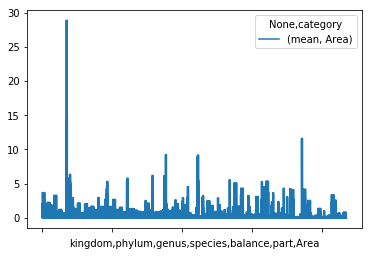

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
groupedDF.xs(['mean'], axis=1).plot()